# Projecto MLOPS

In [18]:
import pandas as pd 
import numpy as np
import os
from sklearn.impute import SimpleImputer

In [19]:
df = pd.read_csv("./archive/WA_Fn-UseC_-Telco-Customer-Churn.csv", sep = ',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


ValueError: could not convert string to float: 'Female'

Ahora vamos a mirar cuantos valores nulos tenemos para cada columna

In [8]:
df.isnull().sum()

# 2️⃣ Drop columns with more than 50% missing values
threshold = 0.5
missing_fraction = df.isnull().mean()
cols_to_drop = missing_fraction[missing_fraction > threshold].index
df = df.drop(columns=cols_to_drop)
print(f"Dropped columns: {list(cols_to_drop)}")

# 3️⃣ Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# 4️⃣ Impute numerical columns (mean or median)
num_imputer = SimpleImputer(strategy='median')  # or strategy='mean'
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# 5️⃣ Impute categorical columns (mode or placeholder)
cat_imputer = SimpleImputer(strategy='most_frequent')  # or fill with 'Unknown'
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# 6️⃣ Verify that missing values are handled
print("Missing values after imputation:")
print(df.isnull().sum())



Dropped columns: []
Missing values after imputation:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [9]:
# 1. Asegurar que columnas numéricas sean numéricas (float/int)
# 'TotalCharges' suele cargarse como objeto porque tiene espacios vacíos " "
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Llenar los nulos generados (espacios vacíos) con 0 o la media (opcional, pero recomendado)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 2. Asegurar que columnas categóricas sean objeto/string
# 'SeniorCitizen' viene como 0/1 (int), pero conceptualmente es categórica
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

# Verificar tipos de datos
print("Tipos de datos corregidos:")
print(df.dtypes)

# 3. Eliminar duplicados exactos (filas completas repetidas)
duplicados_totales = df.duplicated().sum()
print(f"\nFilas duplicadas eliminadas: {duplicados_totales}")
df.drop_duplicates(inplace=True)

# 4. Verificar duplicados en CustomerID
# Esto es crítico: un ID no debería tener dos filas distintas
ids_duplicados = df[df.duplicated(subset=['customerID'], keep=False)]

if not ids_duplicados.empty:
    print(f"\n¡Atención! Se encontraron {len(ids_duplicados)} entradas con customerID duplicado:")
    print(ids_duplicados[['customerID', 'Tenure', 'MonthlyCharges']].head())
else:
    print("\nNo existen customerID duplicados. La integridad es correcta.")

Tipos de datos corregidos:
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Filas duplicadas eliminadas: 0

No existen customerID duplicados. La integridad es correcta.


In [10]:
binary_mapping = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map(binary_mapping)

# -----------------------------------------
# 6️⃣ One-Hot Encode multi-class categoricals
multi_class_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

# -----------------------------------------
# Confirm final dataset
print(df.head())
print(df.info())


   customerID  gender SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0           0.0        1           0     1.0   
1  5575-GNVDE       1           0.0        0           0    34.0   
2  3668-QPYBK       1           0.0        0           0     2.0   
3  7795-CFOCW       1           0.0        0           0    45.0   
4  9237-HQITU       0           0.0        0           0     2.0   

   PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  ...  \
0             0                 1           29.85         29.85  ...   
1             1                 0           56.95       1889.50  ...   
2             1                 1           53.85        108.15  ...   
3             0                 0           42.30       1840.75  ...   
4             1                 1           70.70        151.65  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            F

In [11]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0.0,1,0,1.0,0,1,29.85,29.85,...,False,False,False,False,False,False,False,False,True,False
1,5575-GNVDE,1,0.0,0,0,34.0,1,0,56.95,1889.50,...,False,False,False,False,False,True,False,False,False,True
2,3668-QPYBK,1,0.0,0,0,2.0,1,1,53.85,108.15,...,False,False,False,False,False,False,False,False,False,True
3,7795-CFOCW,1,0.0,0,0,45.0,0,0,42.30,1840.75,...,True,False,False,False,False,True,False,False,False,False
4,9237-HQITU,0,0.0,0,0,2.0,1,1,70.70,151.65,...,False,False,False,False,False,False,False,False,True,False


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# List of numeric columns to scale
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 1️⃣ StandardScaler (zero mean, unit variance)
std_scaler = StandardScaler()
df[numeric_cols] = std_scaler.fit_transform(df[numeric_cols])



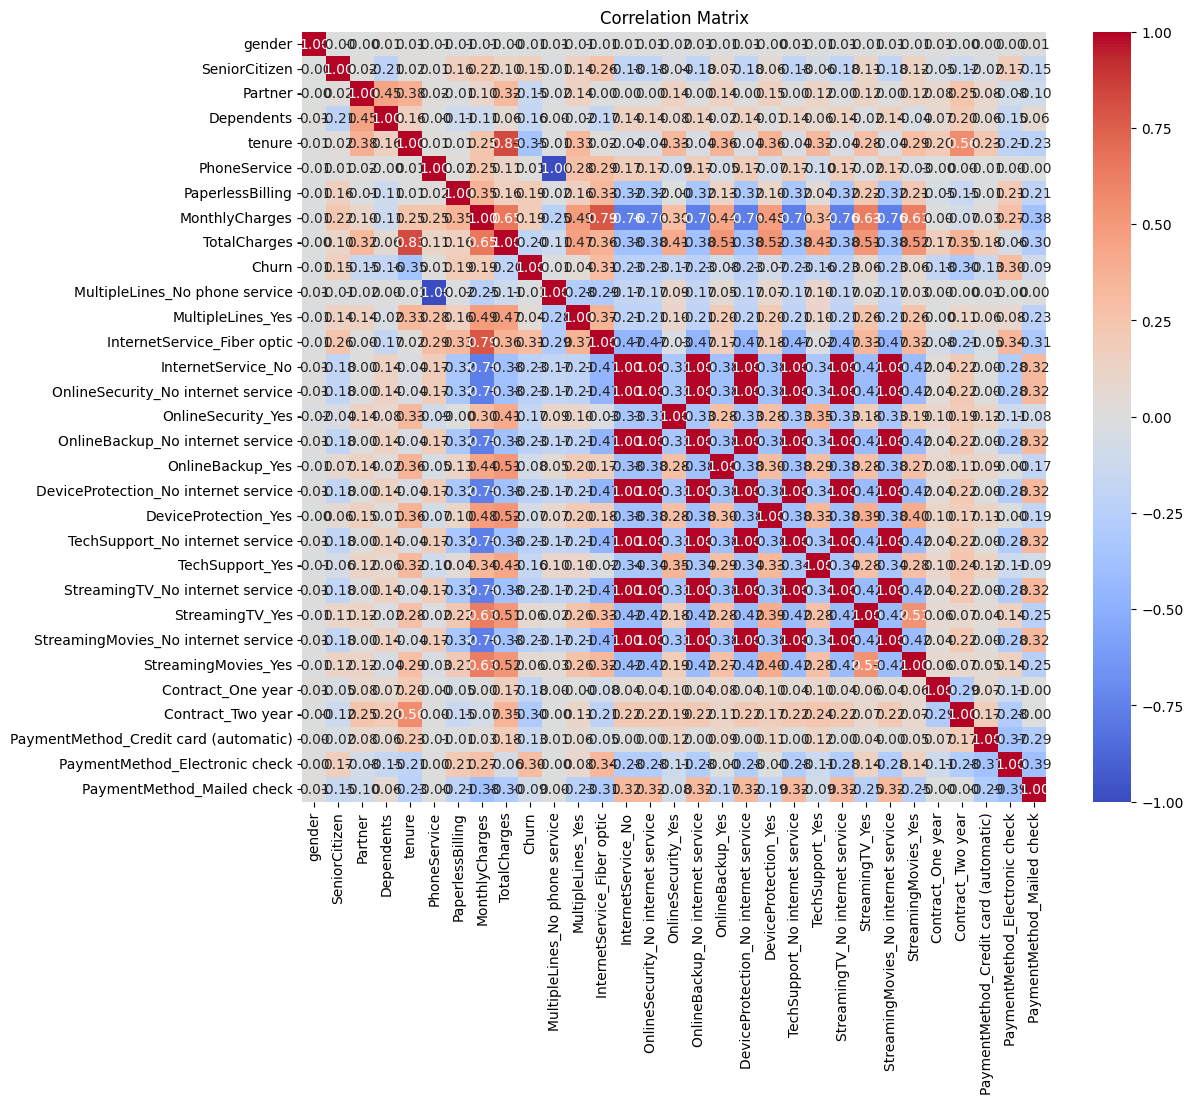

AttributeError: module 'pandas' has no attribute 'np'

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_sin_id = df.iloc[:,1:]
# -------------------------------
# 1️⃣ Compute correlation matrix
corr_matrix = df_sin_id.corr()

# -------------------------------
# 2️⃣ Visualize correlation matrix (optional)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# -------------------------------
# 3️⃣ Identify highly correlated features
# For example, correlation threshold = 0.9
threshold = 0.9
upper = corr_matrix.where(pnp.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]
print(f"Highly correlated features to drop: {to_drop}")

# -------------------------------
# 4️⃣ Drop highly correlated features
df_reduced = df_sin_id.drop(columns=to_drop)

# -------------------------------
# 5️⃣ Check final dataset shape
print(f"Original dataset shape: {df.shape}")
print(f"Reduced dataset shape: {df_reduced.shape}")
